In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import plotnine as pn
import seaborn as sns 

import scipy.signal
import scipy.stats

import utils
import torch

from einops import rearrange, reduce, repeat

from sklearn.cluster import DBSCAN
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler



In [71]:
import importlib
importlib.reload(utils)
# %matplotlib widget


<module 'utils' from '/home/acercyc/projects/Keio Testing_analysis/src/utils.py'>

In [10]:
# subj = utils.ExpInfo.getSubjIDs()[0]
subj = utils.ExpInfo.getSubjIDs()[0]#'K-Reg-H-3'
task = utils.ExpInfo.taskName[0]
model = utils.Model.load(subj, task, path='TrajNet_train_onUse').eval()


In [3]:
df_beh = utils.LoadData.behaviorData(subj, task)

(<Figure size 720x720 with 2 Axes>, <AxesSubplot:xlabel='x', ylabel='y'>)

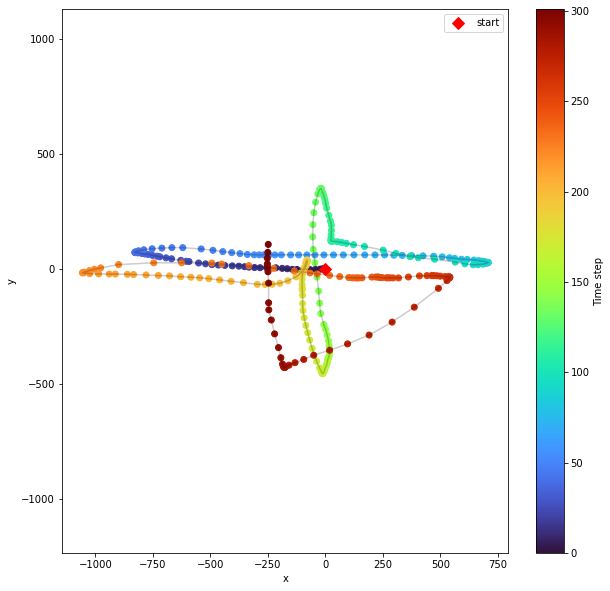

In [4]:
trialno = 1
nTime = 60
df = utils.LoadData.mouseMovement(subj, task, trialno+1)
d_trial = df[["x-shift", "y-shift"]].values
d_trial_cum = d_trial.cumsum(axis=0)
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
utils.Plot.traj_withColour(d_trial_cum[:, 0], d_trial_cum[:, 1], fig, ax)

In [5]:
x = utils.DataProcessing.rollingWindow_from_df(df, nTime, 1)
y = model(torch.from_numpy(x).double())
h_ = model.model.x_hidden.detach().cpu().numpy()
y = y.detach().cpu().numpy()


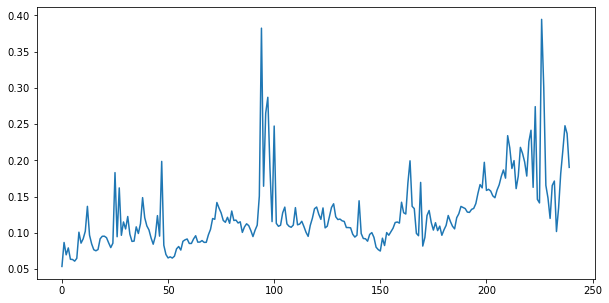

In [8]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
dist = utils.DataProcessing.diff(h_, measure='euclidean')
ax.plot(dist)


# ---------------------------------- filter ---------------------------------- #
# b, a = scipy.signal.butter(3, 10, 'highpass', fs=60)
# dist = scipy.signal.filtfilt(b, a, dist)
# dist = scipy.ndimage.gaussian_filter1d(dist, 0.5, order=0)
# dist = np.abs(dist)
# ax.plot(dist)

# b, a = scipy.signal.butter(3, 7, 'highpass', fs=60)
# dist = scipy.signal.filtfilt(b, a, dist)
# taps = scipy.signal.firwin(5, 20, pass_zero='highpass', fs=60)
# Use lfilter to filter x with the FIR filter.
# dist = scipy.signal.lfilter(taps, 1.0, dist)

# -------------------------------- convolution ------------------------------- #
# window = np.exp( np.arange(10))
# window = window / np.sum(window)
# dist = scipy.signal.convolve(dist, window)
# ax.plot(dist)



[2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 4 4 6 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 5 5 5 3 0 0 0 0 0 0 0 0 0 0 0 0 0]


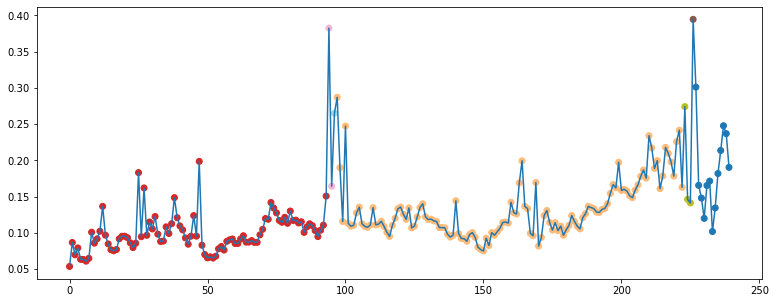

In [7]:
from matplotlib.pyplot import connect
import sklearn.cluster
# labels = sklearn.cluster.DBSCAN(eps=0.2, min_samples=1, metric='euclidean', p=2).fit_predict(h_)


connectivity = np.diagflat(np.ones(len(h_)-1), 1)
labels = sklearn.cluster.AgglomerativeClustering(n_clusters=None, 
                                                 distance_threshold=0.26, 
                                                 connectivity=connectivity, 
                                                 linkage='average').fit_predict(h_)

# labels[labels==-1] = max(labels)+1
print(labels)
fig, ax = plt.subplots(1, 1, figsize=(13, 5))
ax.plot(dist)
ax.scatter(range(len(dist)), dist, c=labels[1:], cmap='tab20')
noGroup = np.where(labels==-1)
noGroup = np.array(noGroup)-1
ax.scatter(noGroup, dist[noGroup], c='r', marker='x', s=100)

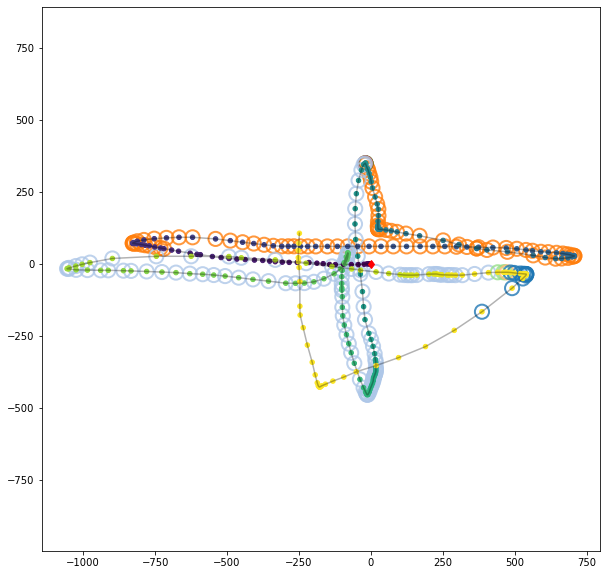

In [9]:
def traj_withCluster(x, y, labels, align='e', ax=None, seqColormap='viridis'):
    n = len(x)
    nW = len(labels)
    if align == 's':
        offset = 0
    elif align == 'e':
        offset = n - nW
    elif align == 'c':
        offset = (n - nW)//2
    else:
        raise ValueError('align must be e, s, or c')

    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(10, 10))
        
    # plot line
    ax.plot(x, y, 'k', alpha=0.3)     
            
    # plot starting point
    ax.plot(x[0], y[0], 'dr')
    
    # plot labels
    cmap = mpl.cm.get_cmap('tab20')
    nCluster = len(set(labels))+1
    edgecolors = cmap(labels)
    sc = ax.scatter(x[offset:offset+nW], y[offset:offset+nW],
                    edgecolors=edgecolors,
                    s=200,
                    linewidths=2,
                    facecolors='none',
                    alpha=0.8)    
    
    # plot sample points with color
    cmap = mpl.cm.get_cmap(seqColormap)
    colors = cmap(range(n))
    ax.scatter(x, y, c=colors, s=20, alpha=1)               
    ax.axis('equal')
    if ax is None:
        return fig, ax
    

traj_withCluster(d_trial_cum[:, 0], d_trial_cum[:, 1], labels, align='c')


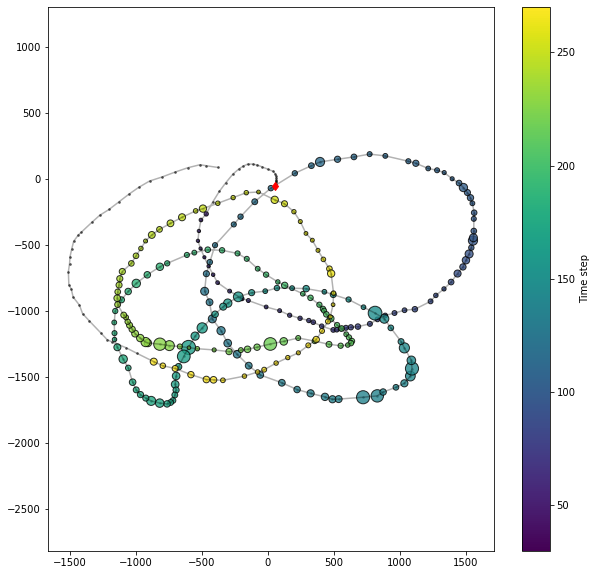

In [79]:
def traj_withWeight(x, y, w, align='e', ax=None, seqColormap='viridis', minSize=10):
    ''' Plot trajectory with weights
    align: 'e'(default) end, 's' start, 'c' center
    '''
    from sklearn.preprocessing import minmax_scale
    w = minmax_scale(w, feature_range=(minSize, 200))
    n = len(x)
    nW = len(w)
    if align == 's':
        offset = 0
    elif align == 'e':
        offset = n - nW
    elif align == 'c':
        offset = (n - nW)//2
    else:
        raise ValueError('align must be e, s, or c')

    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(10, 10))

    # plot line
    ax.plot(x, y, 'k', alpha=0.3)

    # plot sample points with color
    cmap = mpl.cm.get_cmap(seqColormap)
    colors = cmap(range(n))
    # ax.scatter(x, y, c=colors, s=minSize)
    ax.scatter(x, y, c='k', s=3, alpha=0.5)

    # plot starting point
    ax.plot(x[0], y[0], 'dr')

    # plot weights
    sc = ax.scatter(x[offset:offset+nW], y[offset:offset+nW],
                    c=colors[offset:offset+nW, :],
                    s=w,
                    edgecolors='k',
                    alpha=0.8)
    ax.axis('equal')
    norm = mpl.colors.Normalize(vmin=offset, vmax=offset+nW)
    cbar = fig.colorbar(mpl.cm.ScalarMappable(cmap=seqColormap, norm=norm), ax=ax)
    cbar.set_label('Time step')
    if ax is None:
        return fig, ax




traj_withWeight(d_trial_cum[:, 0], d_trial_cum[:, 1], dist**2, align='c')


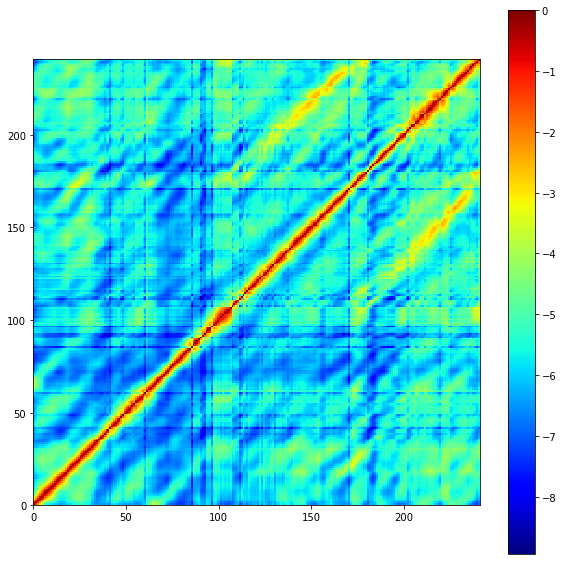

In [80]:
from scipy.spatial import distance
measure = 'mahalanobis'
# measure = 'euclidean'
# measure = 'correlation'
# measure = 'cosine'

Y = distance.pdist(h_, measure)
Y = distance.squareform(Y)
Y = -Y
fig, ax = plt.subplots(1, 1, figsize=(10,10))
im = ax.pcolormesh(Y, cmap='jet')
plt.colorbar(im)
ax.set_aspect('equal')

# ruptures segmentation

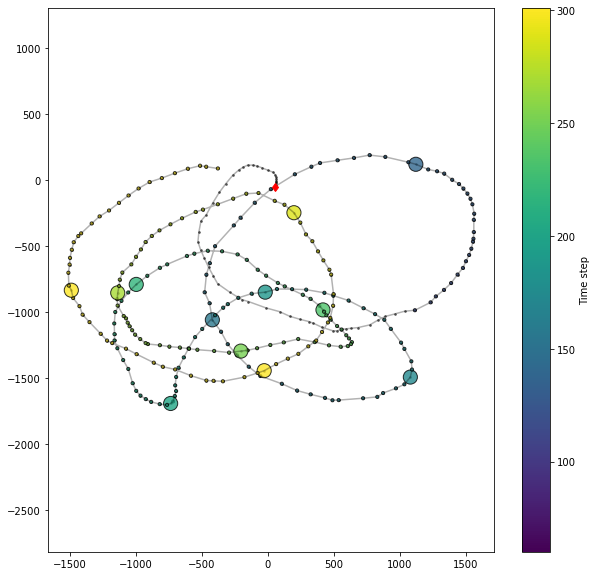

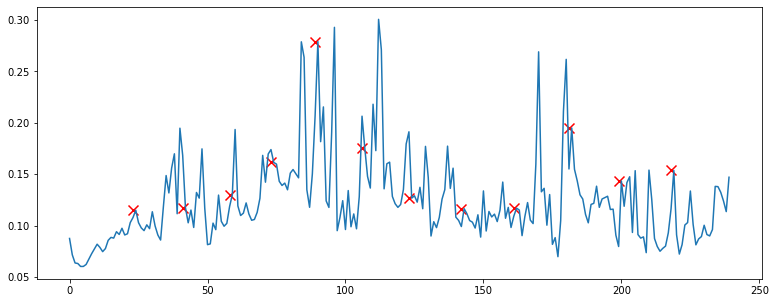

In [83]:
import ruptures as rpt

labels = rpt.KernelCPD(kernel="rbf", min_size=1).fit_predict(h_, pen=5)

# labels = rpt.Pelt('l2', jump=2, min_size=1).fit_predict(h_, 12)

# labels = rpt.BottomUp('l2', jump=1, min_size=1).fit_predict(h_, epsilon=100)

# labels = rpt.Window(model='l2', width=20, jump=1, min_size=1).fit_predict(h_, pen=2) #epsilon=30


labels = np.array(labels[:-1])-1

w = np.zeros(h_.shape[0])
w[labels] = 1
traj_withWeight(d_trial_cum[:, 0], d_trial_cum[:, 1], w, align='e')


fig, ax = plt.subplots(1, 1, figsize=(13, 5))
ax.plot(dist)
ax.scatter(labels-1, dist[labels], c='r', marker='x', s=100)


# Exp level

In [5]:
X, H, Y = utils.LoadData.xhy(subj, task)

In [6]:
H_diff = [utils.DataProcessing.diff(x) for x in H]
H_diff_ = np.concatenate(H_diff, axis=0)


In [85]:
threshold = np.quantile(H_diff_, 0.99)

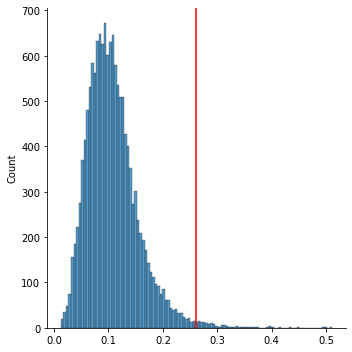

In [88]:
sns.displot(H_diff_)
plt.axvline(threshold, c='r')


# Reconstruction loss
Not very useful...

In [483]:
# se = (y - x) ** 2
# se = rearrange(se, 's t f -> s (t f)')
# mse = np.mean(se, axis=1)
# fig, ax = plt.subplots(1, 1, figsize=(10,5))
# ax.plot(scipy.stats.zscore(mse))
# ax.plot(scipy.stats.zscore(dist))



In [484]:
# traj_withWeight(d_trial_cum[:, 0], d_trial_cum[:, 1], mse**3, align='c')

# neighbor and distance

In [485]:
# h__ = np.diff(h_, axis=0)
# h__ = np.abs(h__)
# h__ = np.cumsum(h__, axis=1)
# h__.shape


In [486]:
# h__ = np.diff(h_, axis=0)
# h__ = np.abs(h__)
# sns.displot(h__)


In [487]:
# dd = h__[:, -1] - h__[:,0]
# m = np.argsort(dd)
# m = m[::-1]
# m

In [488]:
# traj_withWeight(d_trial_cum[:, 0], d_trial_cum[:, 1], dd**4, align='c')


In [489]:
# fig, ax = plt.subplots(1, 1, figsize=(8,8))
# ax.plot(h__[:, :].T)